In [1]:
import pandas as pd
import torch
from transformers import XLNetForSequenceClassification, XLNetTokenizer
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy   

c:\Users\AIML\anaconda3\envs\aiml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
df = pd.read_csv('balanced_dataset.csv')
X = df[['text','useful']]
y = df['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [4]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

# Define a function to manually pad sequences
def pad_sequences(input_ids, max_length):
    padded_input_ids = []
    attention_masks = []
    
    for seq in input_ids:
        seq_len = len(seq)
        if seq_len < max_length:
            # Pad the sequence
            padded_seq = seq + [0] * (max_length - seq_len)
            attention_mask = [1] * seq_len + [0] * (max_length - seq_len)
        else:
            # Truncate the sequence
            padded_seq = seq[:max_length]
            attention_mask = [1] * max_length
        
        padded_input_ids.append(padded_seq)
        attention_masks.append(attention_mask)
    
    return padded_input_ids, attention_masks

# Concatenate 'text', 'useful', 'funny' columns into one string for each row
train_texts = (X_train['text'] + " " + X_train['useful'].astype(str)).tolist()
test_texts = (X_test['text'] + " " + X_test['useful'].astype(str)).tolist()

# Tokenize and pad the training data
train_encodings = [tokenizer.encode_plus(
    sentence,
    add_special_tokens=True,
    max_length=128,
    padding=False  # Prevent padding during tokenization
) for sentence in train_texts]

# Tokenize and pad the testing data
test_encodings = [tokenizer.encode_plus(
    sentence,
    add_special_tokens=True,
    max_length=128,
    padding=False  # Prevent padding during tokenization
) for sentence in test_texts]

# Extract input_ids
train_input_ids = [encoding['input_ids'] for encoding in train_encodings]
test_input_ids = [encoding['input_ids'] for encoding in test_encodings]

# Manually pad the sequences
train_input_ids, train_attention_mask = pad_sequences(train_input_ids, max_length=128)
test_input_ids, test_attention_mask = pad_sequences(test_input_ids, max_length=128)

# Convert lists to tensors
train_input_ids = torch.tensor(train_input_ids)
train_attention_mask = torch.tensor(train_attention_mask)

test_input_ids = torch.tensor(test_input_ids)
test_attention_mask = torch.tensor(test_attention_mask)

# Map the labels to integers (assuming 'y_train' and 'y_test' are your labels)
label_mapping = {'genuine': 0, 'fake': 1}

# Ensure y_train and y_test are Series containing labels
y_train = y_train.map(label_mapping)
y_test = y_test.map(label_mapping)

# Convert them to PyTorch tensors
train_labels = torch.tensor(y_train.values, dtype=torch.long)
test_labels = torch.tensor(y_test.values, dtype=torch.long)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [5]:
# Create a Dataset class
class TextDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': self.labels[idx]
        }

In [6]:
from torch.utils.data import TensorDataset, DataLoader

# Create TensorDataset
train_dataset = TensorDataset(train_input_ids, train_attention_mask, train_labels)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = TensorDataset(test_input_ids, test_attention_mask, test_labels)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [7]:
# Load the XLNet model
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=2)

# Define the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

# Define the device

model.to(device)

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0-11): 12 x XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (sequence_summary): SequenceSummary(
    (summary): Linear(in_features=768, out_features=768, bias=True)
    (activation): Tanh()
    (first_dropout): Identity()
    (last

In [8]:
import torch.nn.functional as F

def train(model, device, loader, optimizer):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for batch in loader:
        input_ids, attention_mask, labels = [item.to(device) for item in batch]

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs[0]  # Get logits from the tuple

        # Compute the loss
        loss = F.cross_entropy(logits, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(loader)
    accuracy = correct / total

    return avg_loss, accuracy


In [9]:
def evaluate(model, device, loader):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in loader:
            input_ids, attention_mask, labels = [item.to(device) for item in batch]

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs[0]  # Get logits from the tuple

            # Compute the loss
            loss = F.cross_entropy(logits, labels)

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(loader)
    accuracy = correct / total

    return avg_loss, accuracy, preds, labels


In [10]:
# Early Stopping
best_valid_loss = float('inf')
patience = 5
patience_counter = 0

train_losses = []
valid_losses = []


In [11]:
for epoch in range(50):  # Large number of epochs to allow for early stopping
    avg_train_loss, train_accuracy = train(model, device, train_loader, optimizer)
    avg_valid_loss, valid_accuracy, _, _ = evaluate(model, device, test_loader)

    train_losses.append(avg_train_loss)
    valid_losses.append(avg_valid_loss)

    print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Epoch {epoch + 1}, Valid Loss: {avg_valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}")

    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        best_model = deepcopy(model)
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break


Epoch 1, Train Loss: 0.4768, Train Accuracy: 0.7767
Epoch 1, Valid Loss: 0.4345, Valid Accuracy: 0.8061
Epoch 2, Train Loss: 0.3975, Train Accuracy: 0.8293
Epoch 2, Valid Loss: 0.4326, Valid Accuracy: 0.8016
Epoch 3, Train Loss: 0.3236, Train Accuracy: 0.8689
Epoch 3, Valid Loss: 0.4787, Valid Accuracy: 0.8020
Epoch 4, Train Loss: 0.2414, Train Accuracy: 0.9088
Epoch 4, Valid Loss: 0.5963, Valid Accuracy: 0.7972
Epoch 5, Train Loss: 0.1707, Train Accuracy: 0.9374
Epoch 5, Valid Loss: 0.6854, Valid Accuracy: 0.7905
Epoch 6, Train Loss: 0.1233, Train Accuracy: 0.9570
Epoch 6, Valid Loss: 0.7852, Valid Accuracy: 0.7857
Epoch 7, Train Loss: 0.0836, Train Accuracy: 0.9707
Epoch 7, Valid Loss: 0.8002, Valid Accuracy: 0.7888
Early stopping triggered.


In [12]:
# Evaluate the best model on the test set
_, test_accuracy, all_preds, all_labels = evaluate(best_model, device, test_loader)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.8016


In [13]:
from sklearn.metrics import classification_report

# Assuming all_labels and all_preds are your true labels and predicted labels
all_labels_cpu = all_labels.cpu().numpy()  # Move to CPU and convert to NumPy array
all_preds_cpu = all_preds.cpu().numpy()    # Move to CPU and convert to NumPy array

# Print the classification report
print(classification_report(all_labels_cpu, all_preds_cpu, target_names=['genuine', 'fake']))


              precision    recall  f1-score   support

     genuine       0.89      1.00      0.94         8
        fake       1.00      0.83      0.91         6

    accuracy                           0.93        14
   macro avg       0.94      0.92      0.93        14
weighted avg       0.94      0.93      0.93        14



In [14]:
from sklearn.metrics import confusion_matrix

# Ensure labels and predictions are on the CPU and as NumPy arrays
all_labels_cpu = all_labels.cpu().numpy()  # Ground truth labels
all_preds_cpu = all_preds.cpu().numpy()    # Predicted labels or probabilities (use predicted labels here)

# Convert probabilities to binary predictions if needed
threshold = 0.5
binary_preds = (all_preds_cpu >= threshold).astype(int)

# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(all_labels_cpu, binary_preds).ravel()

# Calculate metrics
accuracy = (tp + tn) / (tp + fp + tn + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

# Print results
print("Confusion Matrix:")
print(f"TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")
print("\nMetrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")


Confusion Matrix:
TP: 5, FP: 0, TN: 8, FN: 1

Metrics:
Accuracy: 0.9286
Precision: 1.0000
Recall: 0.8333
F1 Score: 0.9091


In [15]:
from sklearn.metrics import roc_curve, auc

# Ensure tensors are moved to CPU and converted to NumPy
all_labels_cpu = all_labels.cpu().numpy()  # Convert labels to CPU and NumPy
all_preds_cpu = all_preds.cpu().numpy()    # Convert predictions/probabilities to CPU and NumPy

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(all_labels_cpu, all_preds_cpu)
roc_auc = auc(fpr, tpr)

print(f"ROC AUC: {roc_auc}")


ROC AUC: 0.9166666666666667


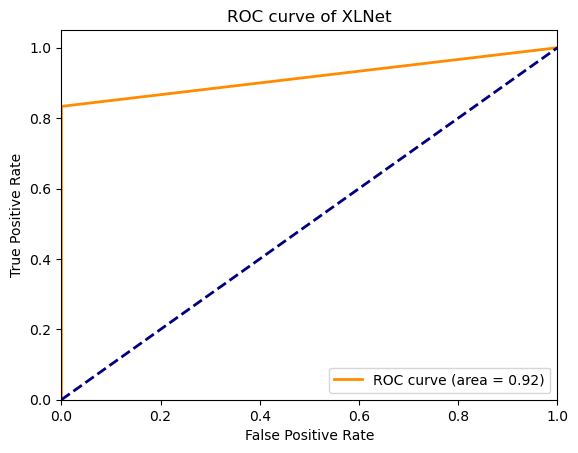

In [16]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of XLNet')
plt.legend(loc="lower right")
plt.show()

In [17]:
from sklearn.metrics import classification_report
print(classification_report(all_labels_cpu, all_preds_cpu))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.83      0.91         6

    accuracy                           0.93        14
   macro avg       0.94      0.92      0.93        14
weighted avg       0.94      0.93      0.93        14

